In [13]:
!pip install seaborn
import seaborn as sns

  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
You should consider upgrading via the '/home/delta/Desktop/meta/ontology-graphs/venv/bin/python3 -m pip install --upgrade pip' command.


In [1]:
import json
import glob
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import groupby
from anytree import PreOrderIter
from anytree.search import findall
from comorbid_graphs import ComorbidGraph, ComorbidGraphNode

## Get Analysed Data

In [2]:
def generate_test_data(data_file, analysis_files=[]):
    with open(data_file) as f:
        data = json.load(f)
    cg = ComorbidGraph(data, node_type=ComorbidGraphNode, assign_ids=True, root_name='dsm-v')
    
    # analyse
    analysis_cgs = []
    for file in analysis_files:
        with open(file) as f:
            data = json.load(f)
        name = file[file.rfind('/')+1:].replace('.json','')
        analysis_cgs.append(
            ComorbidGraph(data, node_type=ComorbidGraphNode, assign_ids=True, root_name=name)
        )
    print(f"Analysing with {len(analysis_cgs)} analysis graphs.")
    cg.process_graph(analysis_cgs)
    with open(data_file.replace('.json', '_labelled.json'), 'w+') as f:
        json.dump(cg.export(), f)
    return cg

def open_existing_data(data_file):
    with open(data_file.replace('.json', '_labelled.json')) as f:
        data = json.load(f)
    return ComorbidGraph(data, node_type=ComorbidGraphNode, assign_ids=True, root_name='dsm-v')

In [3]:
annotations = glob.glob('../examples/ontologies/mental_health/annotations/*')
annotations

['../examples/ontologies/mental_health/annotations/representation_MF-core.json',
 '../examples/ontologies/mental_health/annotations/syndrome_ND.json',
 '../examples/ontologies/mental_health/annotations/general symptom_symp.json',
 '../examples/ontologies/mental_health/annotations/bodily disposition_MF-core.json',
 '../examples/ontologies/mental_health/annotations/neurological disease_ND.json',
 '../examples/ontologies/mental_health/annotations/neurological and physiological symptom_symp.json',
 '../examples/ontologies/mental_health/annotations/head and neck symptom_symp.json',
 '../examples/ontologies/mental_health/annotations/interpersonal process_MF-core.json',
 '../examples/ontologies/mental_health/annotations/disease of mental health_HumanDO.json',
 '../examples/ontologies/mental_health/annotations/pathological bodily process_ND.json',
 '../examples/ontologies/mental_health/annotations/mental disorder_MD-core.json',
 '../examples/ontologies/mental_health/annotations/consciousness_M

### DSM-V Data

In [4]:
%%time
data_file = '../examples/dsm_v/dsm_v.json'
analysis_files = [
    '../examples/dsm_v/dsm_v.json',
    *annotations
]
generate_test_data(data_file, analysis_files)

Analysing with 19 analysis graphs.

Extracting labels from 1875 nodes.
Exctracted: 0
Exctracted: 100
Exctracted: 200
Exctracted: 300
Exctracted: 400
Exctracted: 500
Exctracted: 600
Exctracted: 700
Exctracted: 800
Exctracted: 900
Exctracted: 1000
Exctracted: 1100
Exctracted: 1200
Exctracted: 1300
Exctracted: 1400
Exctracted: 1500
Exctracted: 1600
Exctracted: 1700
Exctracted: 1800
CPU times: user 15min 19s, sys: 243 ms, total: 15min 19s
Wall time: 15min 19s


In [5]:
cg = open_existing_data(data_file)
print(cg.explore(maxlevel=2))

dsm-v
├── Neurodevelopmental Disorders
├── Schizophrenia Spectrum and Other Psychotic Disorders
├── Bipolar and Related Disorders
├── Depressive Disorders
├── Anxiety Disorders
├── Obsessive-Compulsive and Related Disorders
├── Trauma and Stressor-Related Disorders
├── Dissociative Disorders
├── Somatic Symptom and Related Disorders
├── Feeding and Eating Disorders
├── Elimination Disorders
├── Sleep-Wake Disorders
├── Sexual Dysfunctions
├── Gender Dysplioria
├── Disruptive, Impulse-Control, and Conduct Disorders
├── Substance-Related and Addictive Disorders
├── Neurocognitive Disorders
├── Personality Disorders
├── Paraphilic Disorders
├── Other Mental Disorders
├── Medication-Induced Movement Disorders and Other Adverse Effects of Medication
└── Other Conditions That May Be a Focus of Clinicai Attention



In [6]:
len([i for i in cg.get_nodes() if len(i.annotation_list) > 0])

1615

### Create Labels Table

In [22]:
def intersect_series(series):
    cleaned = [i for i in series if i is not None]
    if cleaned == []:
        return []
    return set.intersection(*cleaned)

def union_series(series):
    cleaned = [i for i in series if i is not None]
    if cleaned == []:
        return []
    return set.union(*cleaned)

def pivot_group(data_list, pivot='ancestor', attribute='name'):
    return {
        i:set([j[attribute] for j in gr])
        for i, gr in groupby(data_list, lambda x: x[pivot])
    }

def create_nodes_labels_table(result_cg, filter_out_sections=False):

    # create dataframe
    df = pd.DataFrame([
        {
            "node":i.name,
            **pivot_group(i.annotation_list, 'ancestor'),
            #**pivot_group(i.annotation_list, 'parent'),
        }
        for i in result_cg.get_nodes()
        if i.annotation_list != [] and (i.type and i.type == 'section')
    ]).replace({np.nan: set()})
    if len(df):
        df.set_index('node', inplace=True)

    # per node shared labels
    df['all'] = df.apply(union_series, axis=1)
    df['common'] = df.iloc[:,:-1].apply(intersect_series, axis=1)

    # per analysis category 
    shared = {}
    for name, values in df.iteritems():
        shared[name] = union_series(values)
    shared['node'] = 'total'
    df = df.append(pd.DataFrame([shared]).set_index('node'))
    return df

### Get crossovers

In [23]:
df = create_nodes_labels_table(cg)
df.head(5)

,dsm_v,disease stage_ND,syndrome_ND,mental process_MF-core,bodily disposition_MF-core,interpersonal process_MF-core,disease of mental health_HumanDO,general symptom_symp,nervous system symptom_symp,pathological mental process_MD-core,disorder_ND,nervous system disease_HumanDO,pathological bodily process_ND,neurological disease_ND,head and neck symptom_symp,neurological and physiological symptom_symp,mental disorder_MD-core,all,common
node,,,,,,,,,,,,,,,,,,,
Diagnostic Criteria,{Intellectual Disability },{onset},{ND_0003015},"{planning, thinking}",{intelligence},{communication},{intellectual disability},{},{},{},{},{},{},{},{},{},{},"{intelligence, thinking, ND_0003015, intellect...",{}
Specifiers,{Specifiers},{},{ND_0003015},{},{},{},{},{},{},{},{},{},{},{},{},{},{},"{ND_0003015, Specifiers}",{}
Diagnostic Features,{Diagnostic Criteria},{onset},{ND_0003015},{planning},{personality},{communication},{intellectual disability},{weakness},{},{},{},{},{},{},{},{},{},"{personality, weakness, Diagnostic Criteria, N...",{}
Associated Features Supporting Diagnosis,{Intellectual Disability },{},{ND_0003015},{hearing},{},{communication},{},{},{aggressive behavior},{suicide},{injury},{},{},{},{},{},{},"{injury, suicide, hearing, aggressive behavior...",{}
Prevalence,"{Intellectual Disability , Prevalence}",{},{ND_0003015},{},{},{},{},{},{},{},{},{},{},{},{},{},{},"{ND_0003015, Intellectual Disability , Prevale...",{}


### Plot

In [24]:
plot_df = df.applymap(len).sort_values(['all'])
plot_df.tail(5)

,dsm_v,disease stage_ND,syndrome_ND,mental process_MF-core,bodily disposition_MF-core,interpersonal process_MF-core,disease of mental health_HumanDO,general symptom_symp,nervous system symptom_symp,pathological mental process_MD-core,disorder_ND,nervous system disease_HumanDO,pathological bodily process_ND,neurological disease_ND,head and neck symptom_symp,neurological and physiological symptom_symp,mental disorder_MD-core,all,common
node,,,,,,,,,,,,,,,,,,,
Diagnostic Features,2,0,1,1,0,0,1,2,1,1,0,1,1,0,0,1,0,12,0
Prevalence,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,0,12,0
Comorbidity,2,1,1,1,1,1,1,1,1,1,0,0,0,0,0,1,0,12,0
Comorbidity,1,1,1,2,0,1,1,1,1,1,0,1,0,0,0,2,1,14,0
total,150,6,5,16,7,2,65,15,20,43,8,20,3,15,14,25,9,423,0


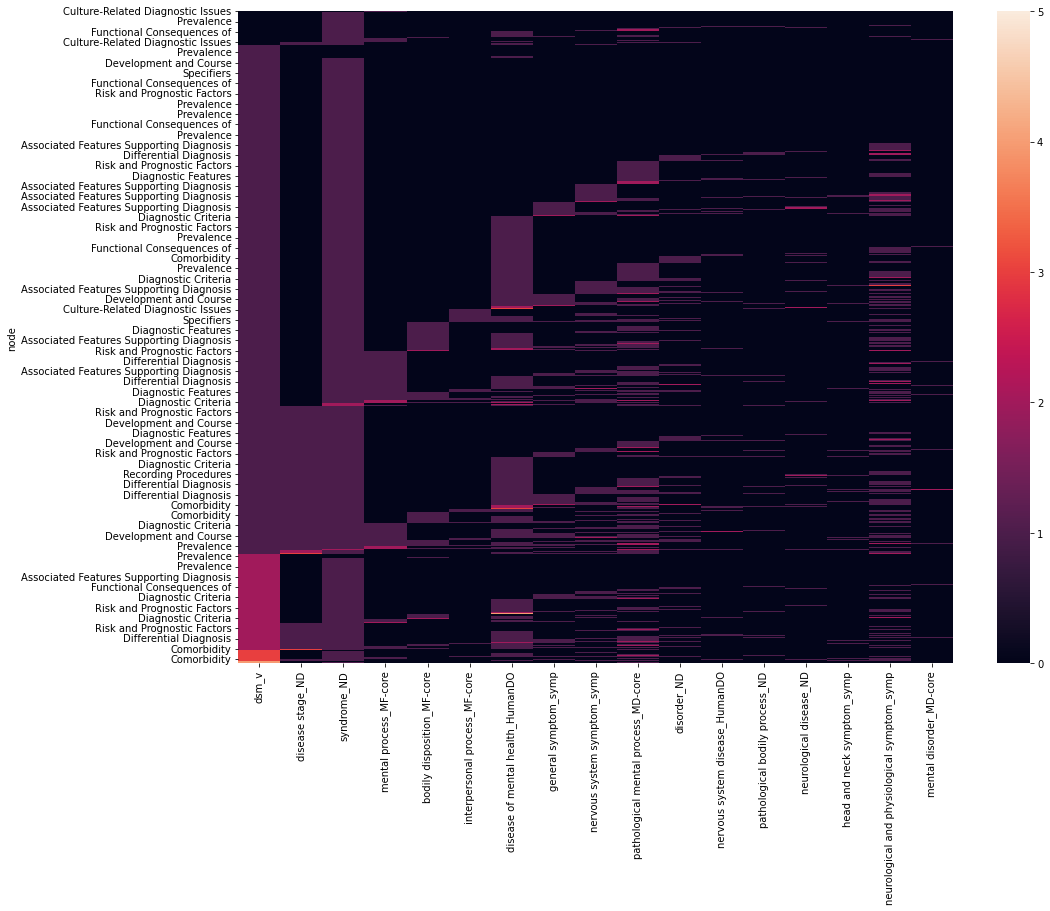

In [25]:
%matplotlib inline
numerical_df = plot_df.iloc[:-1,:-2]
# optional: resize images from now on
plt.rcParams["figure.figsize"] = (16, 12)

# numeric_only_columns is a list of columns of the DataFrame
# containing numerical data only
# annot = True to visualize the correlation factor

sns.heatmap(numerical_df.sort_values(list(numerical_df.columns)))
plt.show()